In [1]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=54a1ba3a5f75f85839730aa30abc5d972378c08c675ef48755526aa72f89b7bf
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [2]:
!pip install wikipedia-api
!pip install wikipedia
!pip install langdetect

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=8dcdaa9c7459346f67c26c4d101c453e9e11e4ab2c94ebd941a661afb4012a69
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=f53891287de729c169d8386814ad35098bcb62161eee32fa0aa911408f692f4d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


**Data loading and Preprocessing**


*   We will load all the files directly from the Google drive. So first we have to mount the drive into collab notebook.

*   For preprocessing we will only use csv module of python.


In [3]:
import csv
import string
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display
import wikipedia
from langdetect import detect as detect_language
from googletrans import Translator
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize Translator object
translator = Translator()
#setting the device to "cuda" if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounting the google drive

- Upload "train.csv" and "testhindistatements.csv" inside the collab folder in google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

MAX_LENGTH=10

class Vocab_builder:
    def __init__(self):
        self.word_2_index={"<SOS>":0,"<EOS>":1,"<PAD>":2,"<UKN>":3}
        self.index_2_word={0:"<SOS>", 1:"<EOS>", 2:"<PAD>", 3:"<UKN>"}
        self.freq={}
        self.size=4

    def add_this_sentence(self,sentence):
        words=sentence.split(" ")
        for word in words:
            if word not in self.word_2_index:
                #If the word is not there, add it to a new index and store the indexes
                #Initialize the frequency of the word to 1 and increase the size of the vocabulary
                self.word_2_index[word]=self.size
                self.freq[word]=1
                self.index_2_word[self.size]=word
                self.size+=1
            else:
                # If the word is already present then just increase the frequency
                self.freq[word]+=1

In [6]:
#Initilizing the objects of hindi and english vocabularies:
hindi_vocab=Vocab_builder()
eng_vocab=Vocab_builder()

In [7]:
def length(sentence):
    '''
        Function to tell the length of a sentence.
    '''
    return len(sentence.split(" "))

def is_mixed(sentence):
    '''
        This function will return True if a hindi sentence is containing some english character.
    '''
    letters="abcdefghijklmnopqrstuvwxyz"
    for ch in letters:
        if ch in sentence:
            return True
    return False

def preprocess(sentence):
    '''
        This function will apply the neccesary preprocessing to a sentence
    '''
    #First we will remove all punctuations from the sentence
    punctuations=list(string.punctuation)
    cleaned=""
    for letter in sentence:
        if letter not in punctuations:
            cleaned+=letter
    cleaned=cleaned.lower() ## Converting into lowercase
    return cleaned

In [8]:
def clean_the_data(path):
    '''
      This function will load the data and process it line by line.
      It will apply all the preprocessing and make the data ready for further processing.
    '''
    pairs=[]
    with open(path,'rt') as f:
        data=csv.reader(f, delimiter=',')
        row_num=0
        for row in data:
            if row_num!=0:  #We will not process first row as it will contain header
                hindi=row[1]
                eng=row[2]

                if length(hindi)>=MAX_LENGTH or length(eng)>=MAX_LENGTH:  #skipping if length is more than MAX_LENGTH
                    continue
                if not hindi or not eng:  #skipping pair having any NULL value
                    continue
                if is_mixed(hindi):   #skipping sentence if it contains some english word
                    continue
                hindi=hindi.encode('utf-8',errors='ignore').decode('utf-8')
                eng=eng.encode('ascii',errors='ignore').decode('utf-8')
                hindi=preprocess(hindi)
                eng=preprocess(eng)
                #Adding <SOS>, <EOS> and padding tokens
                pair=[hindi.strip(), eng.strip()]

                hin_extra=MAX_LENGTH-len(hindi.strip().split(" "))
                eng_extra=MAX_LENGTH-len(eng.strip().split(" "))

                hindi_vocab.add_this_sentence(pair[0])
                eng_vocab.add_this_sentence(pair[1])
                pair[0]=pair[0].split(" ")
                pair[0].insert(0,"<SOS>")
                pair[0].append("<EOS>")
                pair[0]=pair[0]+["<PAD>"]*(hin_extra)

                pair[1]=pair[1].split(" ")
                pair[1].insert(0,"<SOS>")
                pair[1].append("<EOS>")
                pair[1]=pair[1]+["<PAD>"]*(eng_extra)

                pair[0]=" ".join(pair[0])
                pair[1]=" ".join(pair[1])
                pairs.append(pair)
            row_num+=1
    return pairs

In [9]:
file_path="/content/drive/MyDrive/train-set.csv"       # path of train dataset in the drive


In [10]:
pairs=clean_the_data(file_path)

In [11]:
pairs[10]

['<SOS> लानत है तुम पर <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<SOS> damn you <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']

In [12]:
#Now we need to convert each of this pair into corresponding tensors
def pair_to_tensor(pair):
    '''
    A function to convert a given pair to tensors corresponding to index in vocabulary
    '''
    hindi_sentence=pair[0]
    eng_sentence=pair[1]
    indexes_hindi=[hindi_vocab.word_2_index[word] for word in hindi_sentence.split(' ')]
    indexes_eng=[eng_vocab.word_2_index[word] for word in eng_sentence.split(' ')]
    hindi_tensor=torch.tensor(indexes_hindi, dtype=torch.long, device=device).view(-1,1)
    eng_tensor=torch.tensor(indexes_eng, dtype=torch.long, device=device).view(-1,1)
    return (hindi_tensor, eng_tensor)

In [13]:
hin_tensors=[]
eng_tensors=[]
for pair in pairs:      # we will convert each pair into tensor to process it
    hin,eng=pair_to_tensor(pair)
    hin_tensors.append(hin)
    eng_tensors.append(eng)

In [14]:
class Transformer_model(nn.Module):
    def __init__(self, embed_size, len_hin_vocab, len_eng_vocab, src_pad_index, num_heads, enc_layers, dec_layers, forward_exp, dropout, max_length,device):
        super(Transformer_model,self).__init__()
        self.hin_word_embed=nn.Embedding(len_hin_vocab, embed_size) #shape: (len_hin_vocab, embed_size)
        self.eng_word_embed=nn.Embedding(len_eng_vocab, embed_size) #shape: (len_eng_vocab, embed_size)
        self.hin_positional_embed=nn.Embedding(max_length, embed_size) #shape: (MAX_LENGTH, embed_size)
        self.eng_positional_embed=nn.Embedding(max_length, embed_size)  #shape: (MAX_LENGTH, embed_size)
        self.device=device
        self.transformer_layer=nn.Transformer(embed_size, num_heads,enc_layers, dec_layers, forward_expansion, dropout)
        self.out_fc=nn.Linear(embed_size, len_eng_vocab)    #linear layer to predicted the output word
        self.dropout=nn.Dropout(dropout)
        self.src_pad_index=src_pad_index

    def gen_mask_for_hindi(self, source):
        #need to transpose source as padding need to be of size (batch_size, seq_len) but source is of shape (seq_len, batch_size)
        source=source.transpose(0,1)
        mask=(source==self.src_pad_index) #(mask will contain 1 where there is pad token, and 0 otherwise)
        return mask.to(self.device)

    def forward(self, src, target):
        hin_seq_length, batch_size=src.shape
        eng_seq_length, batch_size=target.shape
        # creating positional embeddings to encode position of words in transformer (it will be just a range array upto max_length)
        hin_positional=torch.arange(0,hin_seq_length).unsqueeze(1).expand(hin_seq_length, batch_size).to(self.device)
        eng_positional=torch.arange(0,eng_seq_length).unsqueeze(1).expand(eng_seq_length, batch_size).to(self.device)
        # calculating embeddings as sum of positional and word embeddings
        hin_embedding=self.dropout(self.hin_word_embed(src)+self.hin_positional_embed(hin_positional))
        eng_embedding=self.dropout(self.eng_word_embed(target)+self.eng_positional_embed(eng_positional))
        # generating padding mask for hindi (source)
        hindi_padding_mask=self.gen_mask_for_hindi(src)
        # using in-built transformer function to generate mask for english (target)
        # It will be in form of a lower-triangular matrix
        eng_mask=self.transformer_layer.generate_square_subsequent_mask(eng_seq_length).to(self.device)
        output=self.transformer_layer(hin_embedding, eng_embedding, src_key_padding_mask=hindi_padding_mask, tgt_mask=eng_mask)
        output=self.out_fc(output)
        return output

**Training the Model**

In [15]:
# defining model parameters
embed_size=512
len_hin_vocab=hindi_vocab.size
len_eng_vocab=eng_vocab.size
padding_idx=eng_vocab.word_2_index["<PAD>"]
num_heads=8
enc_layers, dec_layers= 1,1
dropout=0.10
forward_expansion=4

In [16]:
model=Transformer_model(embed_size, len_hin_vocab, len_eng_vocab, padding_idx, num_heads, enc_layers, dec_layers, forward_expansion, dropout, MAX_LENGTH+2,device).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [17]:
model_available=False # A variable to indicate whether a model is present in the path or not

In [18]:
batch_size=64
optimizer=optim.Adam(model.parameters(),lr=0.001)
PATH="/content/drive/MyDrive/test-statements-phase.csv"

epochs=20
epoch_loss=0.0

criterion=nn.CrossEntropyLoss(ignore_index=padding_idx) #ignore padding index while calculating loss

train_model=True #if need to train the model again, set it to True

if train_model==False:
    model=torch.load(PATH)
else:
    if model_available:
        model=torch.load(PATH)
    batches=len(pairs)//batch_size
    for epoch in range(epochs):
        print(f"epoch {epoch+1}/{epochs}")
        model.eval()
        model.train(True)
        cur_batch=0
        for idx in range(0,len(pairs),batch_size):
            # will do processing for each batch
            cur_batch+=1
            if(cur_batch%100==0):
                print(f"    running batch {cur_batch} of {batches}")
            if idx+batch_size < len(pairs):
                src_batch=hin_tensors[idx:idx+batch_size]
                target_batch=eng_tensors[idx:idx+batch_size]
            else:
                src_batch=hin_tensors[idx:]
                target_batch=eng_tensors[idx:]

            src_batch=torch.cat(src_batch,dim=1).to(device)    #shape: (max_lenbatch_size)
            target_batch=torch.cat(target_batch,dim=1).to(device) #shape: (max_lenbatch_size)
            output=model(src_batch,target_batch[:-1,:])
            output=output.reshape(-1, output.shape[2])

            target=target_batch[1:].reshape(-1)

            optimizer.zero_grad()
            loss=criterion(output,target)

            loss.backward()
            # restrict gradients from exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch loss : {loss.item()}")

        torch.save(model,PATH)
        model_available=True

epoch 1/20
    running batch 100 of 861
    running batch 200 of 861
    running batch 300 of 861
    running batch 400 of 861
    running batch 500 of 861
    running batch 600 of 861
    running batch 700 of 861
    running batch 800 of 861
Epoch loss : 4.058197021484375
epoch 2/20
    running batch 100 of 861
    running batch 200 of 861
    running batch 300 of 861
    running batch 400 of 861
    running batch 500 of 861
    running batch 600 of 861
    running batch 700 of 861
    running batch 800 of 861
Epoch loss : 3.3856756687164307
epoch 3/20
    running batch 100 of 861
    running batch 200 of 861
    running batch 300 of 861
    running batch 400 of 861
    running batch 500 of 861
    running batch 600 of 861
    running batch 700 of 861
    running batch 800 of 861
Epoch loss : 2.989434242248535
epoch 4/20
    running batch 100 of 861
    running batch 200 of 861
    running batch 300 of 861
    running batch 400 of 861
    running batch 500 of 861
    running batch 600

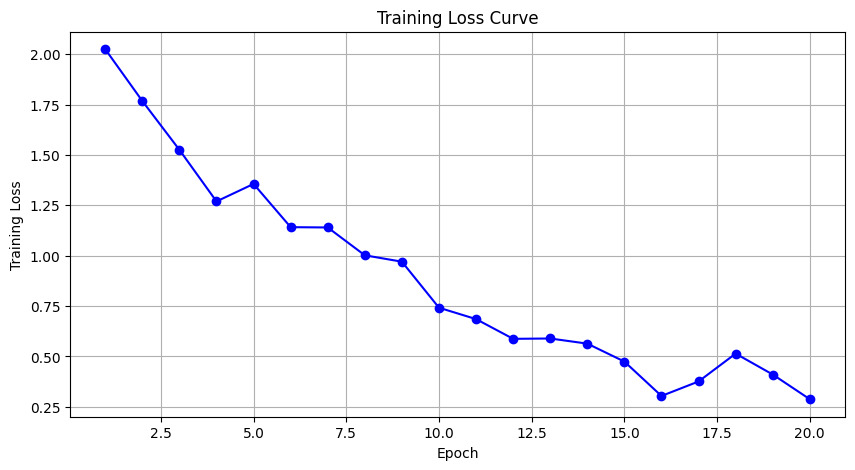

In [19]:
import matplotlib.pyplot as plt

# Loss values from the training process
loss_values = [2.024390935897827, 1.7673678398132324, 1.5250968933105469, 1.269163727760315,
               1.3560009002685547, 1.1413747072219849, 1.1399400234222412, 1.001804232597351,
               0.9701089859008789, 0.7417600154876709, 0.6852189898490906, 0.587337076663971,
               0.5889912247657776, 0.5635097026824951, 0.4744497537612915, 0.3038314878940582,
               0.37576037645339966, 0.5140419602394104, 0.4103344678878784, 0.28767460584640503]

# Number of epochs
epochs = len(loss_values)

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

In [20]:
def clean_sentence(sentence):
    '''
      Function to remove the punctuation from the test sentence
    '''
    punctuations=list(string.punctuation)
    cleaned=""
    for letter in sentence:
        if letter=='<' or letter=='>' or letter not in punctuations:
            cleaned+=letter
    return cleaned

def predict_translation(model,sentence,device,max_length=MAX_LENGTH):
    '''
      function will return the translation predicted by the trained model for each sentence
    '''
    sentence=clean_sentence(sentence)
    tokens=sentence.split(" ")
    indexes=[]
    for token in tokens:
        if token in hindi_vocab.word_2_index:
            indexes.append(hindi_vocab.word_2_index[token])
        else:
            indexes.append(hindi_vocab.word_2_index["<UKN>"])
    indexes=indexes[:MAX_LENGTH+2]  # model is trained on MAX_LENGTH sentences only so it expects sentences of this length only
    tensor_of_sentence=torch.LongTensor(indexes).unsqueeze(1).to(device)
    outputs=[0]   #adding <SOS> in the beginning of output
    for _ in range(max_length):
        target_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
        with torch.no_grad():
            output=model(tensor_of_sentence,target_tensor)
        pred=output.argmax(2)[-1, :].item()

        outputs.append(pred)

        if eng_vocab.index_2_word[pred] =="<EOS>":
            break

    final=[]

    for i in outputs:
        if i == "<PAD>":
            break
        final.append(i)

    final = [eng_vocab.index_2_word[idx] for idx in final]
    translated=" ".join(final)
    return translated

In [21]:
from googletrans import Translator
import time
test_sentences=[pair[0] for pair in pairs[125:150]]
actual_sentences=[pair[1] for pair in pairs[125:150]]
pred_sentences=[]
translator = Translator()

def translate_to_tamil_batch(sentences):
    translations = []
    for sentence in sentences:
        try:
            translation = translator.translate(sentence, src='hi', dest='ta')
            translations.append(translation.text)
        except Exception as e:
            print(f"Error translating: {e}")
            translations.append("")
    return translations

# Split sentences into batches for translation
batch_size = 10
num_batches = len(test_sentences) // batch_size + 1

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(test_sentences))
    batch_sentences = test_sentences[start_idx:end_idx]

    # Translate the batch of sentences to Tamil
    translated_batch = translate_to_tamil_batch(batch_sentences)

    # Predict the translations for the batch of Hindi sentences
    predicted_batch = [predict_translation(model, sentence, device) for sentence in batch_sentences]

    # Print the translations
    for idx, (translated_tamil, predicted) in enumerate(zip(translated_batch, predicted_batch)):
        original_hindi = batch_sentences[idx]
        print("*" * 20)
        print(f"Hindi: {original_hindi}")
        print(f"Tamil: {translated_tamil}")
        print(f"Actual: {actual_sentences[start_idx + idx]}")
        print(f"Predicted: {predicted}")
        print("*" * 20)

        # Pause for a short while to avoid hitting rate limits
        time.sleep(0.5)

********************
Hindi: <SOS> दीदी फ़ूल दे दीजिये <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Tamil: <sos> தீதி ஃபூல் கொடுங்கள் <EOS> <p> <p> <p> <p> <p> <p>
Actual: <SOS> sister flower please <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predicted: <SOS> sister flower please <EOS>
********************
********************
Hindi: <SOS> ग्रन्ट्स <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Tamil: <sos> மானியங்கள் <EOS> <p> <p> <p> <p> <p> <p> <p> <p> <p>
Actual: <SOS> grunts <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Predicted: <SOS> grunts <EOS>
********************
********************
Hindi: <SOS> ca चलिए उसे यहाँ दिखाते हैं <EOS> <PAD> <PAD> <PAD> <PAD>
Tamil: <sos> ca இதை இங்கே காண்பிப்போம் <eos> <p> <p> <p> <p>
Actual: <SOS> ca i think we have that lets show that <EOS> <PAD>
Predicted: <SOS> ca so lets go to show him <EOS>
********************
********************
Hindi: <SOS> नुक्सान किन में जमा हो सकता है <EOS> <PAD> <PAD> <PAD>
Tamil: <SOS> சே

In [22]:
# Opening the file to write the translations
fp=open("/content/drive/MyDrive/answer.txt","w")

In [23]:
# Path of the validation/test data
val_data_path="/content/drive/MyDrive/testhindistatements.csv"
with open(val_data_path, 'rt') as f:
    data=csv.reader(f, delimiter=',')
    row_num=0
    for row in data:
        if row_num==0:
            row_num+=1
            continue
        sentence=row[2].strip()
        translated=predict_translation(model,sentence,device)
        translated=translated.split(" ")[1:-1]  #removing SOS and EOS token before writing to the file
        translated=" ".join(translated)
        fp.write(translated+'\n')
        if row_num%500==0:
            print(f"sentence : {row_num}")
        row_num+=1
fp.close()

sentence : 500
sentence : 1000
sentence : 1500
sentence : 2000
sentence : 2500
sentence : 3000
sentence : 3500
sentence : 4000
sentence : 4500
sentence : 5000


Q&A

In [24]:
# Function to translate input text to English
def translate_to_english(text):
    translation = translator.translate(text, src='auto', dest='en')
    return translation.text

In [25]:
# Function to translate input text to Hindi
def translate_to_hindi(text):
    translation = translator.translate(text, src='auto', dest='hi')
    return translation.text

In [26]:
# Function to translate input text to Tamil
def translate_to_tamil(text):
    translation = translator.translate(text, src='auto', dest='ta')
    return translation.text

In [27]:
# Function to retrieve Wikipedia summary for a given query
def get_wikipedia_summary(query, sentences=2):
    try:
        summary = wikipedia.summary(query, sentences=sentences)
        return summary, None
    except wikipedia.exceptions.PageError:
        return None, "Page does not exist."
    except wikipedia.exceptions.DisambiguationError as e:
        suggestions = e.options
        return None, f"Ambiguous query. Suggestions: {', '.join(suggestions)}"

In [28]:
# Function to check for potentially misleading information
def check_facts(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    keyword_counts = Counter(filtered_tokens)
    misleading_keywords = ['false', 'misleading', 'incorrect', 'inaccurate', 'debunk', 'dispute']
    for keyword in misleading_keywords:
        if keyword in keyword_counts:
            return True
    return False

In [59]:
# Function to handle user input
def handle_input(input_text):
    original_language = detect_language(input_text)
    translated_input = translate_to_english(input_text)
    answer, error_message = get_wikipedia_summary(translated_input)
    if error_message:
        print(f"Error: {error_message}")
        return
    translated_answer_to_hindi = translate_to_hindi(answer)
    translated_answer_to_tamil = translate_to_tamil(answer)

    print("Input text:", input_text)

    if original_language == 'ta':
      print("Original language: TAMIL")
    elif original_language == 'hi':
      print("Original language: HINDI")
    elif original_language == 'en':
      print("Original language: ENGLISH")
    else:
      print("Original language: INPUT IS IN SOME OTHER LANGUAGES")

    print("Translated Input:", translated_input)
    print("English answer:", answer)
    print("Translated answer[HINDI]:", translated_answer_to_hindi)
    print("Translated answer[TAMIL]:", translated_answer_to_tamil)
    if check_facts(answer):
        print("Potential misleading information detected. Fact-check recommended., \n")
    else:
        print("No potential misleading information found., \n")

In [61]:
# Function to handle button click event
def on_button_click(b):
    question = input_widget.value
    handle_input(question)

In [63]:
# Create text input widget
input_widget = widgets.Text(
    description='Enter your question:',
    style={'description_width': 'initial'}
)

# Create button widget
button = widgets.Button(description='Get Answer')

# Attach button click event handler
button.on_click(on_button_click)

# Display widgets
display(input_widget, button)

Text(value='', description='Enter your question:', style=DescriptionStyle(description_width='initial'))

Button(description='Get Answer', style=ButtonStyle())

Input text: இயற்கை மொழி செயலாக்கம் என்றால் என்ன?
Original language: TAMIL
Translated Input: What is a natural language processing?
English answer: Natural language processing (NLP) is an interdisciplinary subfield of computer science and information retrieval. It is primarily concerned with giving computers the ability to support and manipulate human language.
Translated answer[HINDI]: प्राकृतिक भाषा प्रसंस्करण (एनएलपी) कंप्यूटर विज्ञान और सूचना पुनर्प्राप्ति का एक अंतःविषय उप -क्षेत्र है।यह मुख्य रूप से कंप्यूटर को मानव भाषा का समर्थन और हेरफेर करने की क्षमता देने से संबंधित है।
Translated answer[TAMIL]: இயற்கை மொழி செயலாக்கம் (என்.எல்.பி) என்பது கணினி அறிவியல் மற்றும் தகவல் மீட்டெடுப்பின் இடைநிலை துணைத் துறையாகும்.கணினிகளுக்கு மனித மொழியை ஆதரிக்கும் மற்றும் கையாளும் திறனை வழங்குவதில் இது முதன்மையாக அக்கறை கொண்டுள்ளது.
No potential misleading information found., 

Input text: मशीन लर्निंग क्या है?
Original language: HINDI
Translated Input: What is machine learning?
English answer: Mac